In [1]:
import sys
import os

# Add the root directory of the project to the path
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))

# Import the modules
from pyRE.reservoir.models import CoalSeamGasReservoir
from pyRE.reservoir.correlations import Corey2PhaseRelativePermeability
from pyRE.fluid.models import Gas, Water
from pyRE.rock.models import Coal

import numpy as np


In [2]:
# Initialise fluids
gas = Gas() # Use default gas properties
water = Water() # Use default water properties

# Initialise rock
coal = Coal(
    porosity = 0.005,
    permeability = 100,
    density = 1.35,
    compressibility = 4e-5,
    gas_content = 100,
    langmuir_pressure = 371,
    langmuir_volume = 747.7,
    ash_fraction = 0.11,
    moisture_fraction = 0.03
)

# Initialise relative permeability
rel_perm = Corey2PhaseRelativePermeability(
    s1cr = 0.35,
    s2cr = 0,
    n1 = 3,
    n2 = 1,
    kr12c = 1,
    kr21c = 0.7
)

In [3]:
# Create reservoir
reservoir = CoalSeamGasReservoir(
    depth = 2000,
    area = 140,
    thickness = 27,
    net_to_gross = 1,
    rock = coal,
    gas = gas,
    water = water,
    water_gas_relative_permeability = rel_perm
)

reservoir.set_initial_conditions(
    initial_pressure = 1600,
    initial_temperature = 599, # 130F in Rankine
    initial_gas_saturation = 0,
    initial_water_saturation = 1
)

In [4]:
# Calculate initial in-place volumes
reservoir.calculate_initial_in_place_volumes()

{'oil_in_place': 0,
 'gas_in_place': 0.0,
 'water_in_place': 146622.26179875334,
 'adsorbed_gas_in_place': 596.7152226000001}

## King's Z*

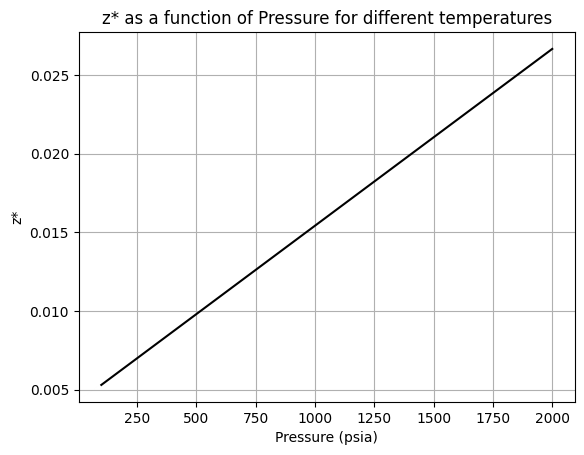

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot z* factor as function of pressure, lines by water saturation
P = np.linspace(100, 2000, 10)
T = [599]
for t in T: 
    z = np.array([reservoir.z_star(pressure = p, temperature = t) for p in P])
    plt.plot(P, z, label=f'Temperature = {t}', color = "k")

plt.xlabel('Pressure (psia)')
plt.ylabel('z*')
plt.title('z* as a function of Pressure for different temperatures')
plt.grid(True)
plt.show()

Initial Gas In-place: Modified King's 3890.29 MMscf; Jensen and Smith's 3890.36 MMscf


/var/folders/08/ghjps1rs42z8rp3h9n_fl03m0000gn/T/ipykernel_53657/1823797174.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


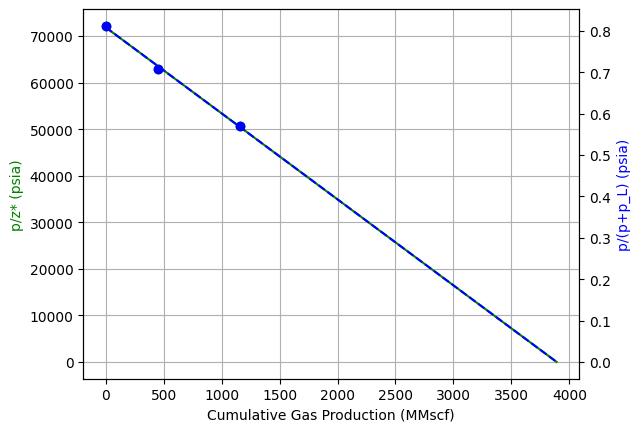

In [7]:
import pandas as pd

observed_data = pd.DataFrame({
    "pressure": [1600, 900, 490],
    "cumulative_gas_production": [0, 455, 1162],
    "cumulative_water_production": [0, 21400, 93500],
})

data_mk, results_mk = reservoir.gas_material_balance(data = observed_data, method = "modified_king")
data_js, results_js = reservoir.gas_material_balance(data = observed_data, method = "jensen_smith")

# Print results
print(f"Initial Gas In-place: Modified King's {results_mk['gas_in_place']:.2f} MMscf; Jensen and Smith's {results_js['gas_in_place']:.2f} MMscf")

#Create a plot of resulting data, Modified KKings on left axis, Jensen and Smith on right axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_mk["cumulative_gas_production"], data_mk["p/z*"], 'go', label='Modified King Gas Production')
ax1.plot([0, results_mk["gas_in_place"]], results_mk["model"].predict(np.array([0, results_mk["gas_in_place"]]).reshape(-1, 1)), 'g-', label="Modified King's Fit")
ax2.plot(data_js["cumulative_gas_production"], data_js["p/(p+p_L)"], 'bo', label='Jensen and Smith Gas Production')
ax2.plot([0, results_js["gas_in_place"]], results_js["model"].predict(np.array([0, results_js["gas_in_place"]]).reshape(-1, 1)), 'b--', label="Jensen and Smith's Fit")
ax1.set_xlabel('Cumulative Gas Production (MMscf)')
ax1.set_ylabel('p/z* (psia)', color='g')
ax2.set_ylabel('p/(p+p_L) (psia)', color='b')
ax1.grid(True)
fig.show()